# Neutron Counts to Volumetric Water Content

A script to translate counts of epithermal neutrons into volumetric water content. The example was generated using data obtained from three Lihium-Foil neutron detectors and a MetSense device that measured atmospheric pressure, relative humidity, and air temperature. All measurements were recorded at hourly intervals

In [95]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit


In [96]:
# Load data
df = pd.read_csv('../datasets/stationary_cosmos_hydroinnova.csv')
df.head()


,RecordNum,Date Time(UTC),P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N1ET_sec,N1T_C,N1RH
0,1,2020/04/10 16:34:00,984.21,984.6,10.9,17.1,7.7,32.7,14.453,2053,3494,12.8,0
1,2,2020/04/10 17:34:00,982.98,983.3,12.3,14.7,8.9,29.0,14.003,2198,3600,14.8,0
2,3,2020/04/10 18:34:00,981.50,981.9,13.5,13.1,10.8,28.9,13.995,2162,3600,15.7,0
3,4,2020/04/10 19:34:00,979.95,980.5,13.8,12.1,11.3,28.1,13.959,2177,3600,16.0,0
4,5,2020/04/10 20:34:00,978.16,978.7,15.5,11.4,13.5,24.9,13.906,2212,3600,17.5,0


In [97]:
# Display range of dataset
print(df['Date Time(UTC)'].iloc[0])
print(df['Date Time(UTC)'].iloc[-1])


 2020/04/10 16:34:00
 2020/06/05 13:34:00


In [98]:
# Re-define variables to match literature notation
P = df['P1_mb']
RH = df['RH_CS215']
T = df['T_CS215']
N_raw = df['N1Cts']


## Step 1: Correct neutron counts

Neutron counts need to be first corrected to eliminate the effect of incoming neutron flux, atmospheric pressure, and water vapor.

In [99]:
# Atmospheric attenuation coefficient (mbar^-1) (see Dong et al. 2014 p.4)
beta = 0.0077

# Long-term average atmospheric pressure for current location in mbars
Pref = 960

# Pressure adjustment factor (fp) [Eq. 1] Hawdon et al. 2014
fp = np.exp(beta*(P - Pref))

# Atmospheric water vapor correction
# saturation vapor pressure in Pascals Eq. 3.8 p. 41 Environmental Biophysics
e_sat = 0.611*np.exp(17.502*T/(T + 240.97))*1000

# Vapor pressure Pascals
Pw = e_sat*RH/100

# 0 g m^-3 (dry air)
A_ref = 0

# Constant in g K/J
C = 2.16679

# Absolute humidity [g/m^3]
A = C*Pw/(T + 273.15)

# Water vapor adjustment factor
fwv = 1 + 0.0054*(A - A_ref)

# Assumes incoming neutron intensity correction fi = 1 
# Visit http://www01.nmdb.eu/nest/index.php to obtain neutron counts for a location
# with similar cutoff rigidity.
# Flutuations are often less than 5%, which means the adjustment factor oscillates around 1.
fi = 1

# Apply correction factors
N_corrected = np.round(N_raw*(fp*fwv/fi))


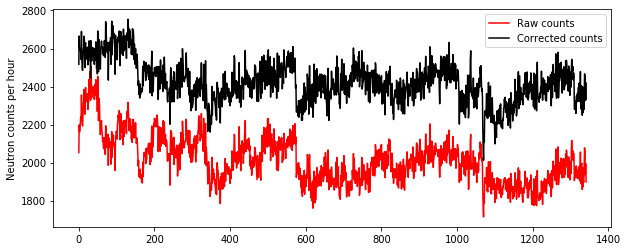

In [100]:
# Plot raw and corrected neutrons
plt.figure(figsize=(10,4))
plt.plot(N_raw,'-r', label='Raw counts')
plt.plot(N_corrected, '-k', label='Corrected counts')
plt.ylabel('Neutron counts per hour')
plt.legend()
plt.show()


## Step 2: Smooth time series of corrected neutron counts

This step aims at emoveing some of the noise due to the random nature of neutron flux

In [101]:
# Smooth corrected neutron counts
N_corrected = signal.medfilt(N_corrected, kernel_size=7)


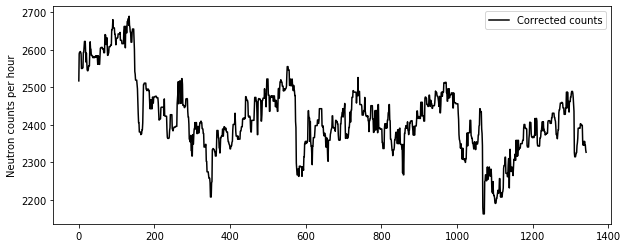

In [102]:
# Plot smoothed corrected neutrons
plt.figure(figsize=(10,4))
plt.plot(N_corrected, '-k', label='Corrected counts')
plt.ylabel('Neutron counts per hour')
plt.legend()
plt.show()


## Step 3: Field calibration

In [103]:
# Values obtained from field sampling in the 0-15 cm layer in each cardinal direction
vwc_cal = [0.2537, 0.3212, 0.3363, 0.2740, 0.22] # Field average soil moisture. All samples have equal weight.
N_cal = [2574, 2434, 2438, 2484, 2700] # Average corrected counts of hour before, during, and after field sampling


In [136]:
# Fit model

# Lattice water g/g
# Value from composite sample or average of multiple field samples
Wlat = 0.033

# Total organic carbon as water equivalent g/g
# ratio of 5 times the molecular weight of water to the molecular weight of cellulose. 
# The factor of 5 is based on 10 H atoms per molecule of cellulose but only 2 per water molecule
TOC = 0.015 #  total organic carbon
Wsom = TOC*0.556

# Bulk density
rho_b = 1.54 # Mg/m3
model = lambda x,N0: (0.0808 / (x/N0 - 0.372) - 0.115 - Wlat - Wsom)*rho_b
par_opt, par_cov = curve_fit(model, N_cal, vwc_cal)

# Counts per hour in scenario with no water (thought to be device specific)
N0 = round(par_opt[0])
print(N0)


4119.0


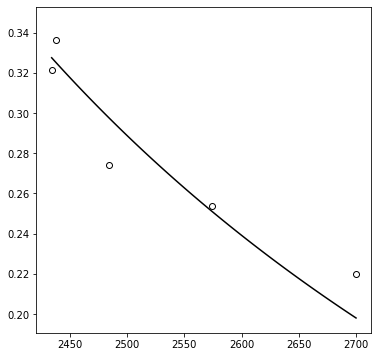

In [137]:
# Plot optimized model
xdata = np.linspace(np.min(N_cal), np.max(N_cal), 100)
ydata = model(xdata, *par_opt)

plt.figure(figsize=(6,6))
plt.scatter(N_cal, vwc_cal, color='k', marker='o', facecolor='w')
plt.plot(xdata, ydata, '-k')
plt.show()

## Step 4: Convert corrected neutron counts into volumetric water content

In [138]:
# Convert neutron counts into volumetric water content (theta)
# Desilets et al 2010.
theta = (0.0808 / (N_corrected/N0 - 0.372) - 0.115 - Wlat - Wsom)*rho_b


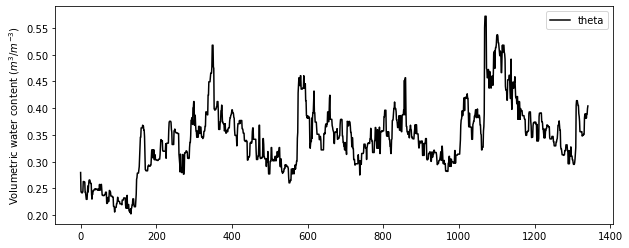

In [139]:
# Plot resulting volumetric water content
plt.figure(figsize=(10,4))
plt.plot(theta, '-k', label='theta')
plt.ylabel('Volumetric water content $(m^3/m^{-3})$')
plt.legend()
plt.show()
